# 1. Classify images based on techniques

This will classify the images into types, based on the microscopy technique used. The categories are as follow:
- bright-field: white background, whole cells
- nissl-stained: hystological staining (violet), yellow background whole cells
- fluorescence: fluorescence staining (DAPI?), black background, nuclei only. 

I used most of the scripts taken from https://www.kaggle.com/nhargan/defining-microscopy-type


## 1.1 Import Modules, define folders and categories

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

For my convenience, I rearranged Ching Hua's set into folders (orig, marked, masks) using 

$ find <folder> -name "*_orig.png" -exec mv {} <new folder> /; 

I do not know how she managed to keep the images and the masks associated, and how she obtained the marked image, but since it was a very good job, we'd better keep it.

In [2]:
train_path = "Ching_Hua/orig/"
file_paths = glob.glob(train_path + "*_orig.png")

In [3]:
type_names = {0: "nissl-stained", 
              1: "fluorescent", 
              2: "bright-field"}

The following will count the violet pixels based on the fact that the 1st channel (Red) will have a bigger value than the 2nd (Green) AND the same is true for 3rd channel (Blue), bigger than 2nd

In [4]:
def get_violet_num(img):
    violet_num = 0
    h, w = img.shape[:2]
    for y in range(h):
        for x in range(w):
            if img[y, x][0] > img[y, x][1] and img[y, x][2] > img[y, x][1]:
                violet_num += 1

    return violet_num

The following will classify the image depending on the number of violet pixel that it show AND on the average intensity of the pixels (bright-field images have average intensities higher because have a major component of white)

In [5]:
def get_microscopy_type(img):
    violet_num = get_violet_num(img)
    if violet_num > 0:
        return 0
    mean_int = img.mean()
    # randomly picked threshold for distinquishing fluorescent and brightfield
    # actually not random, but modified after comments in the thread
    if mean_int > 110:
        return 2
    return 1

I always do checks, but you can delete them if not needed.

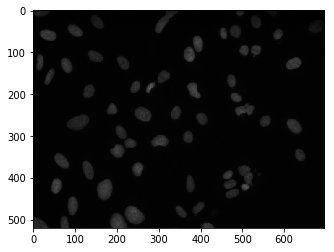

Number of violet pixels
0
Avg pixel intensity
6.84
Image type
fluorescent


In [9]:
#example
img_id = '45'
img_path = os.path.join(train_path, img_id + "_orig.png")
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

#Number of violet pixels
print("Number of violet pixels")
print(get_violet_num(img))

#Average intensity (to differentiate white from black backgrounds)
print("Avg pixel intensity")
mean_int = img.mean()
print(round(mean_int,2))
print("Image type")
print(type_names[get_microscopy_type(img)])

## 1.2 Summarizing information for the Ching Hua set

Here I am building lists containing the type of image, the height and the width, respectively. There might be a faster way to do it (it takes few minutes to run through all images). 

In [7]:
#Building list of image types
types_list = []
for file_path in file_paths:
    img = cv2.imread(file_path)
    types_list.append(type_names[get_microscopy_type(img)])
    
#Same for dimensions
height_list = []
for file_path in file_paths:
    img = cv2.imread(file_path)
    height_list.append(np.size(img,0))
width_list = []
for file_path in file_paths:
    img = cv2.imread(file_path)
    width_list.append(np.size(img,1))

I do not understand why the indexes of the list (which are the file_paths) do not correspond to the numerical order of the image. Shouldn't it be reading the files in alphabetical order, at least? Anyway, to circumvent the problem, I always print also the file path, so to know which files the analysis is referring to. I did several checks and the correspondance is true (i.e., no matter the picture, I obtain correct dimensions and type)

662
Ching_Hua/orig/584_orig.png fluorescent 347 260


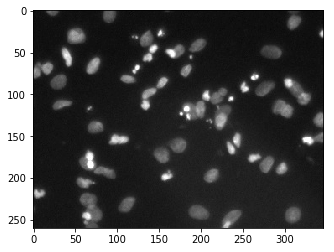

In [8]:
#Check on a random image
rand_idx = np.random.randint(len(types_list))
print(rand_idx)
print(file_paths[rand_idx],
      types_list[rand_idx],
     width_list[rand_idx], 
     height_list[rand_idx])
img = cv2.imread(file_paths[rand_idx])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Since I am still more confident with the dataframe methods that I learned in R, I am building a dataframe in pandas (thanks to the cheatsheets from DataCamp). There might be a better way (array?) but feel free to suggest.

In [9]:
data = {'type': types_list, 
       'height': height_list,
       'width': width_list}

df = pd.DataFrame(data, 
                  index=file_paths, 
                  columns=['type','width', 'height'])

Now I will summarize our output in terms of pixel dimensions (x,y) and mycroscopy type.

In [12]:
print(df['type'].value_counts())

# Counting unique image shapes.
df_shape = pd.DataFrame([[x] for x in zip(df['width'], df['height'])])
df_shape[0].value_counts()

fluorescent      546
nissl-stained    108
bright-field      16
Name: type, dtype: int64


(256, 256)      334
(320, 256)      112
(696, 520)       92
(360, 360)       91
(1024, 1024)     16
(640, 512)       13
(1272, 603)       6
(347, 260)        5
(1388, 1040)      1
Name: 0, dtype: int64

## 2. Image Augmentation